## Notebook to use NMF and Clustering Algorithm

In [3]:
import SimDAT2D.SimDAT2D as sim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IsoDAT2D.IsoDAT2D as iso # import IsoDat2D as iso
from PIL import Image
import pyFAI, fabio
from pyFAI.gui import jupyter
import pyFAI
import os
import matplotlib.pyplot as plt
import masking

In [2]:
!module load opencl

In [4]:
!pip install cupy-cuda12x

In [ ]:
import cupy

In [6]:
!pip install --upgrade pyFAI


In [7]:
import pyFAI
print(pyFAI.opencl.ocl)

None


In [8]:
pyFAI.version

'2024.9.0'

### Creating the synthetic data

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
LaB6_SRM660a


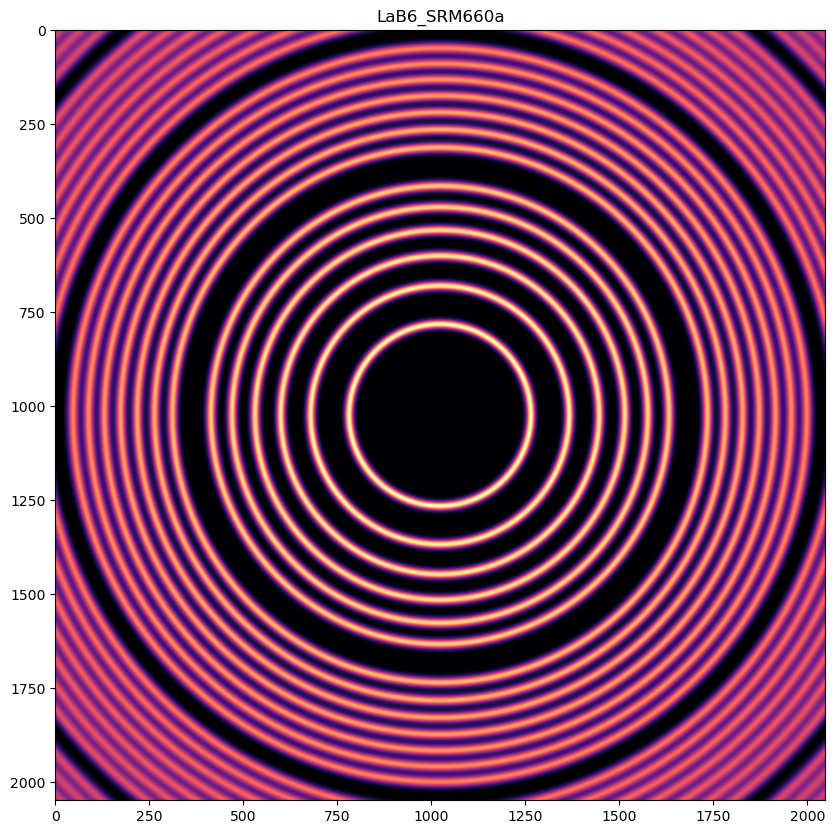

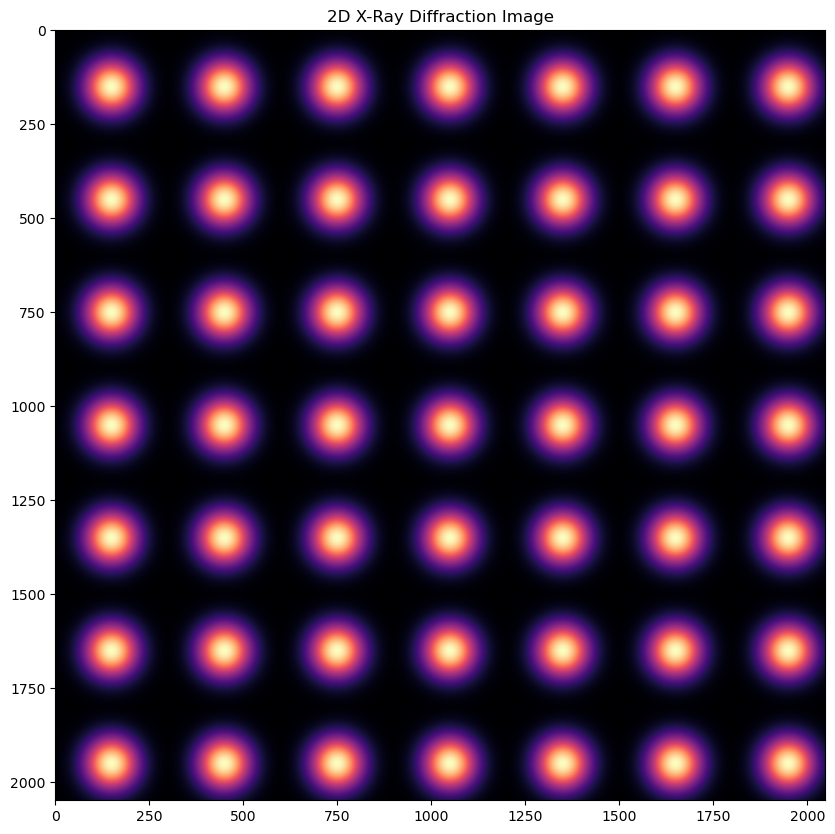

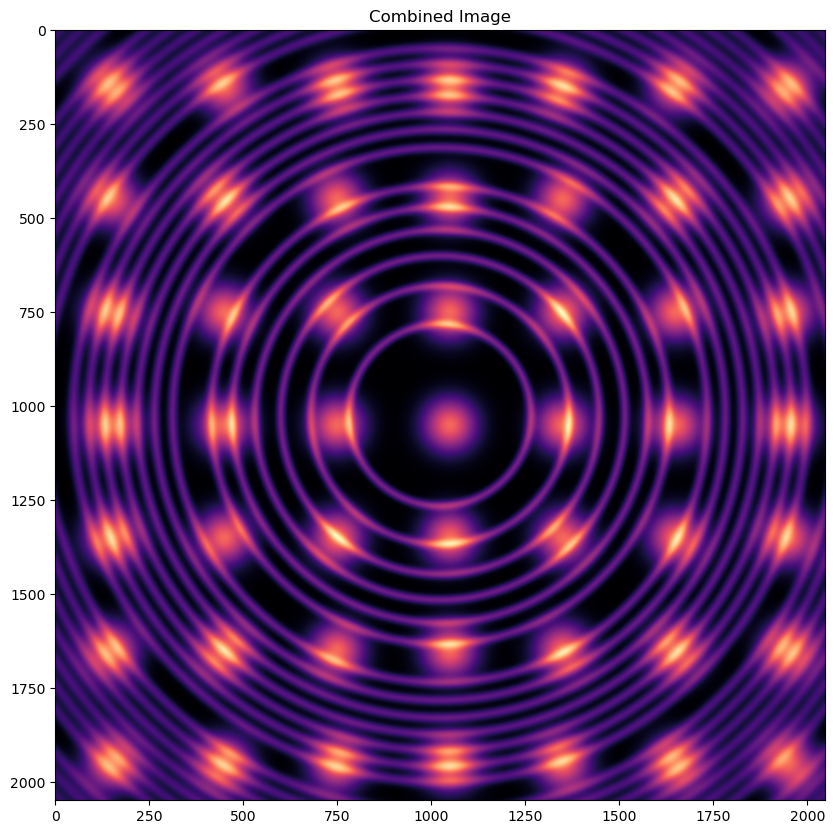

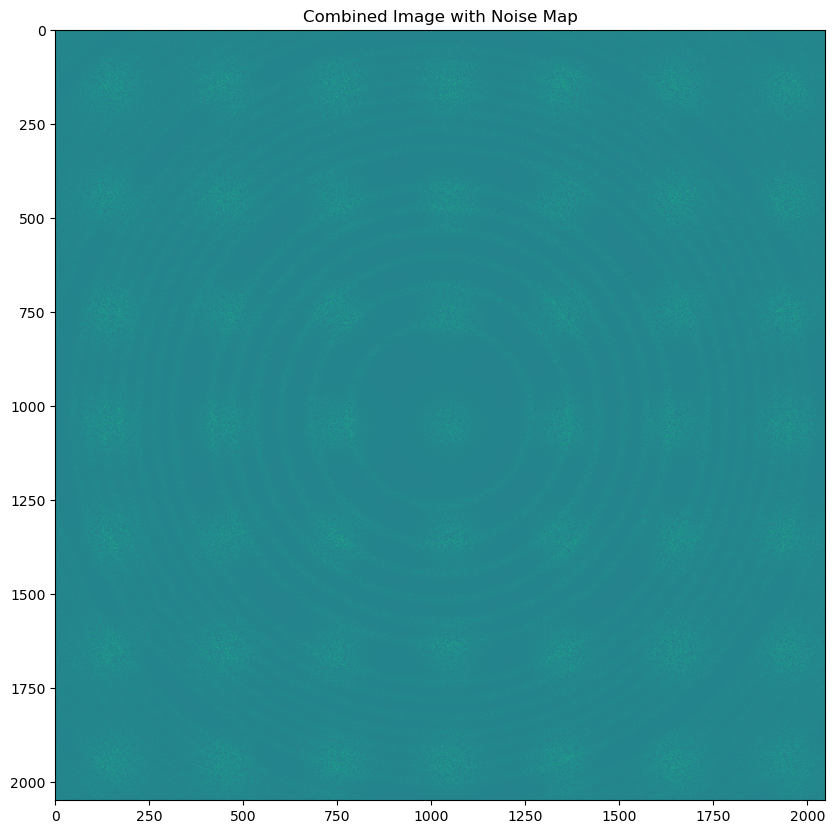

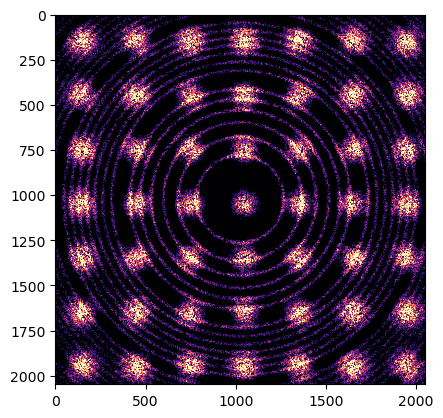

In [9]:
#For ring creation
isotropic_signal = sim.create_isotropic(.4, .5e-10, cmap = 'magma')
#For spot creation
anisotropic_signal = sim.create_anisotropic(25, 50, 300, 300, cmap = 'magma')
#combining signals 
thin_film = sim.combine_image(isotropic_signal, anisotropic_signal*2, cmap= 'magma')
#For noisy data
noisy_im = sim.generate_noisemap(thin_film);
plt.imshow(noisy_im, vmin = 1, vmax = 5, cmap = 'magma')

### Integrating and plotting 1D data

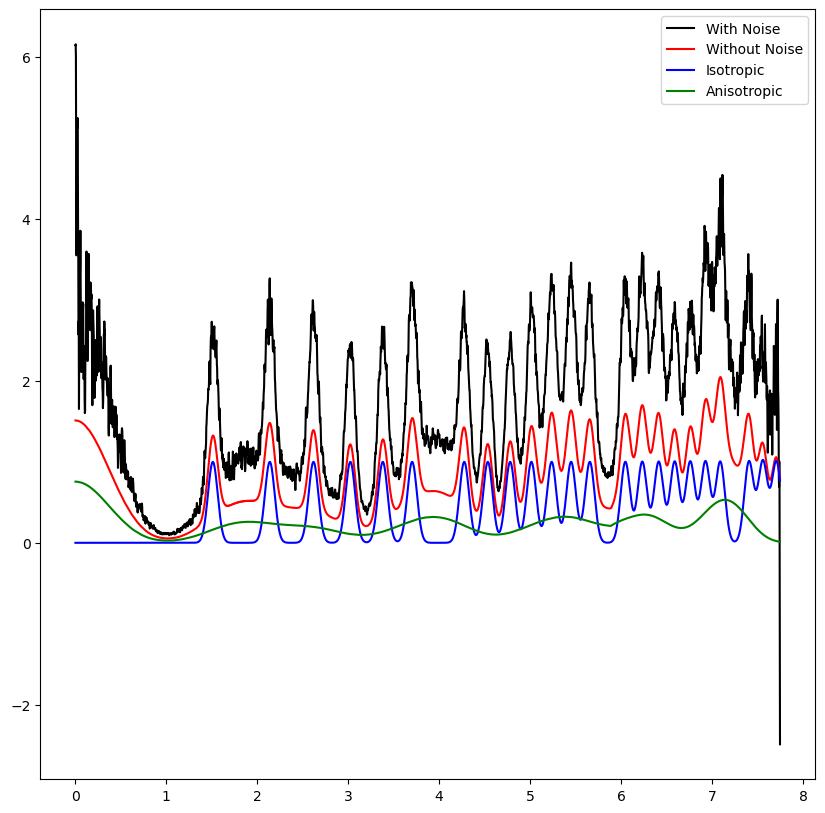

In [ ]:
#using simdat2d to integrate the image
q_noisy, noisy_integrated_im = sim.integrate_image(noisy_im, .4, .5e-10, resolution = 3000)
q, integrated_im = sim.integrate_image(thin_film, .4, .5e-10, resolution = 3000)
q_reg, integrated_reg = sim.integrate_image(isotropic_signal, .4, .5e-10, resolution = 3000)
q_aniso, integrated_aniso = sim.integrate_image(anisotropic_signal, .4, .5e-10, resolution = 3000)

#matplotlib plot
plt.figure(figsize = (10,10))
plt.plot(q_noisy, noisy_integrated_im, c= 'k', label = 'With Noise')
plt.plot(q, integrated_im, c= 'r', label = 'Without Noise')
plt.plot(q_reg, integrated_reg, c= 'b', label = 'Isotropic')
plt.plot(q_aniso, integrated_aniso, c= 'g', label = 'Anisotropic')
plt.plot()
plt.legend()

### Generating mask for 360 integration

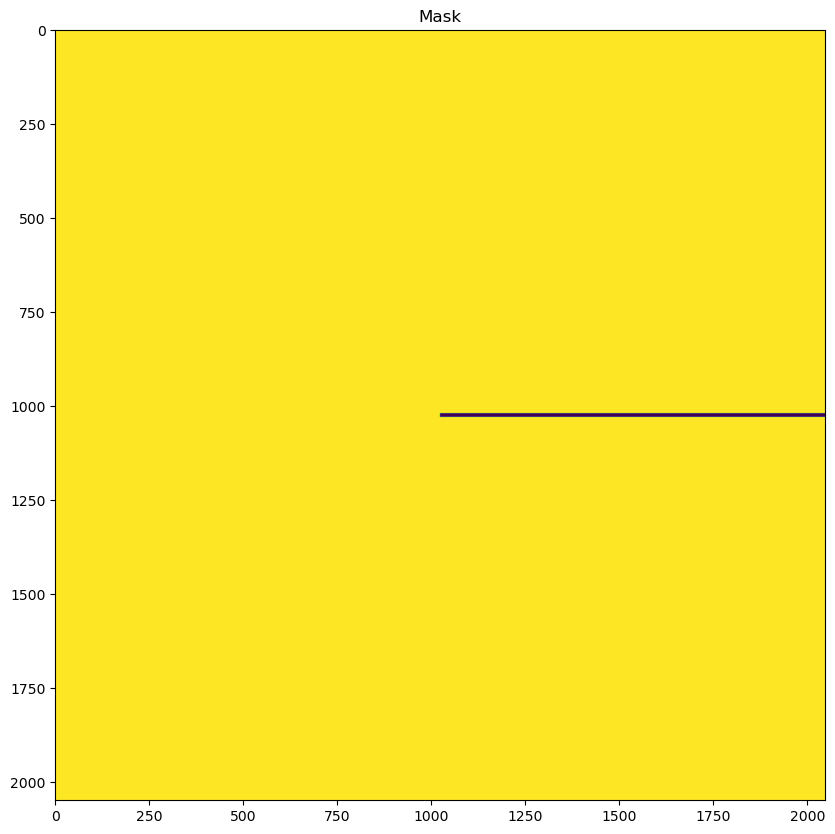

In [11]:
mask = sim.create_mask(thin_film, 5)

In [6]:
def time_function(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

In [11]:
import time
import cv2

# @time_function
def image_rotation(image, angle, show = False):
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    if show == True:
        #display the rotated image
        plt.figure(figsize=(10, 10))
        plt.imshow(rotated_image, cmap='viridis')
        plt.title("Rotated Image")
        plt.show()
    return rotated_image

In [8]:
import time

@time_function
def image_rotation_old(image, angle, show = False):
    """
    This function rotates the combined image by a user specified angle amount, if the angle specified is 1, the result is that the combined image is rotated by one degree.
    
    Parameters:
        image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        """
    pil_format = Image.fromarray(image)
    rotated_image = pil_format.rotate(angle)
    rotated_image = np.array(rotated_image)
    
    if show == True:
        #display the rotated image
        plt.figure(figsize=(10, 10))
        plt.imshow(rotated_image, cmap='viridis')
        plt.title("Rotated Image")
        plt.show()
    return rotated_image


In [10]:
#test old and new rotation function performance
for i in range(0, 360, 45):
        #rotate the mask for the combined image
        rotated_image = image_rotation(thin_film, i)
        rotated_image = image_rotation_old(thin_film, i)
        print('-----------------------------------------')

image_rotation executed in 0.0047 seconds
image_rotation_old executed in 0.0115 seconds
-----------------------------------------
image_rotation executed in 0.0083 seconds
image_rotation_old executed in 0.0299 seconds
-----------------------------------------
image_rotation executed in 0.0066 seconds
image_rotation_old executed in 0.0175 seconds
-----------------------------------------
image_rotation executed in 0.0072 seconds
image_rotation_old executed in 0.0218 seconds
-----------------------------------------
image_rotation executed in 0.0042 seconds
image_rotation_old executed in 0.0119 seconds
-----------------------------------------
image_rotation executed in 0.0061 seconds
image_rotation_old executed in 0.0216 seconds
-----------------------------------------
image_rotation executed in 0.0052 seconds
image_rotation_old executed in 0.0177 seconds
-----------------------------------------
image_rotation executed in 0.0054 seconds
image_rotation_old executed in 0.0192 seconds
--

### Check CPU version and GPU version results the same

In [24]:
# link: https://pyfai.readthedocs.io/en/v2023.1/usage/tutorial/Parallelization/GPU-decompression.html#Using-the-decompression-on-the-GPU
import pyFAI.azimuthalIntegrator as AI
import pyopencl.array as cla

combined_image = thin_film
distance = .4
wavelength = .5e-10
resolution = 3000
# mask = None
show = False
radial_range = None

 # Initialize the detector
dete = pyFAI.detectors.Perkin()
p1, p2, p3 = dete.calc_cartesian_positions()
poni1 = p1.mean()
poni2 = p2.mean()

target = (0,0)
ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
#integrate the combined image using the azimuthal integrator

%time res0 = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask, method=("bbox", "csr", "opencl", target))


CPU times: user 1.19 s, sys: 257 ms, total: 1.45 s
Wall time: 678 ms


In [25]:
engine

In [26]:
engine = ai.engines[res0.method].engine
omega = ai.solidAngleArray()
omega_crc = engine.on_device["solidangle"]
image_d = cla.to_device(engine.queue,combined_image)
%time res1 = engine.integrate_ng(image_d, solidangle=omega, solidangle_checksum=omega_crc)

CPU times: user 590 µs, sys: 932 µs, total: 1.52 ms
Wall time: 1.49 ms


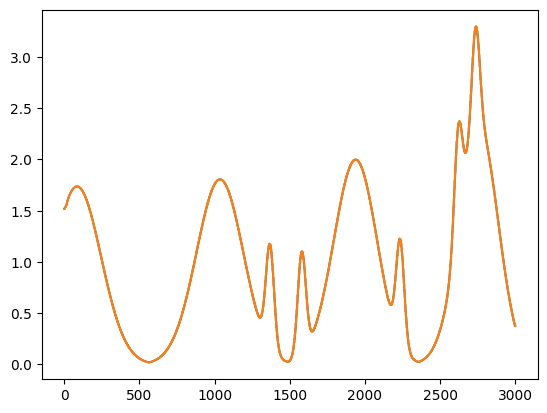

In [27]:
plt.plot(res0.intensity)
plt.plot(res1.intensity)

# Rotate and integrate image - GPU version

In [20]:
import pyFAI.azimuthalIntegrator as AI
import pyopencl.array as cla


@time_function
def rotate_integrate_image_gpu(combined_image,angle_of_rotation, distance, wavelength, resolution = 3000, mask = None, show = True, radial_range = None):
    """
    This function integrates the combined image using the azimuthal integrator and displays the 1D image.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
    """
    data = {}
    #initialize the azimuthal integrator
    
     # Initialize the detector
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = p1.mean()
    poni2 = p2.mean()
    
    target = (0,0)
    ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
    #initialize engine
    res0 = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask, method=("bbox", "csr", "opencl", target))
    
    # Get the engine from res0
    engine = ai.engines[res0.method].engine
    omega = ai.solidAngleArray()
    omega_crc = engine.on_device["solidangle"]
    for i in range(0, 360, angle_of_rotation):
        # start_time = time.time()
        #rotate the mask for the combined image
        rotated_image = image_rotation(combined_image, i)
    
        rotated_image_d = cla.to_device(engine.queue,rotated_image)
    
        res1 = engine.integrate_ng(rotated_image_d, solidangle=omega, solidangle_checksum=omega_crc)
        # print(time.time() - start_time)
        data[i] = res1.intensity
        
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10, 10))
    for j in range(0, 360, angle_of_rotation):
            plt.plot(q, (df[j]+ j*.01), alpha = .55, c = 'black')
    plt.xlabel('q A $^(-1)$')
    plt.ylabel('Intensity')
    plt.title("Waterfall Plot of Rotated 1D X-Ray Diffraction Images")
    plt.show()        
    
    return df

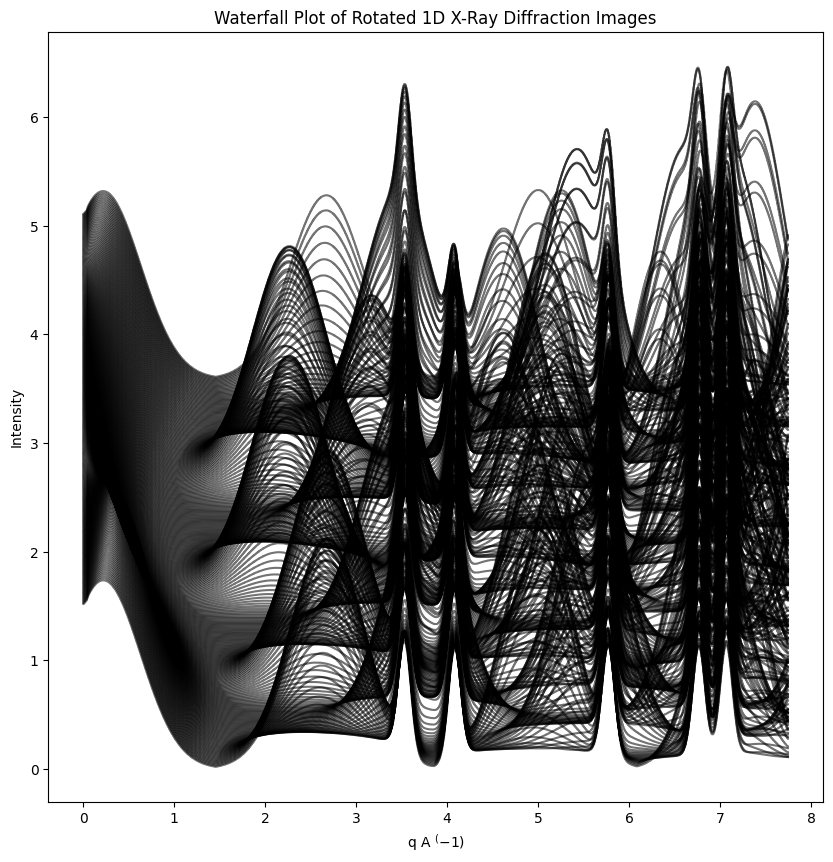

rotate_integrate_image_gpu executed in 7.4977 seconds
CPU times: user 20.5 s, sys: 5.95 s, total: 26.4 s
Wall time: 7.5 s


In [28]:
%%time
data = rotate_integrate_image_gpu(thin_film, 1, .4, .5e-10, resolution = 3000, mask = mask)

/home/mlotfollahi/ondemand/Megan/SimDAT2D/SimDAT2D/SimDAT2D/SimDAT2D.py:349: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


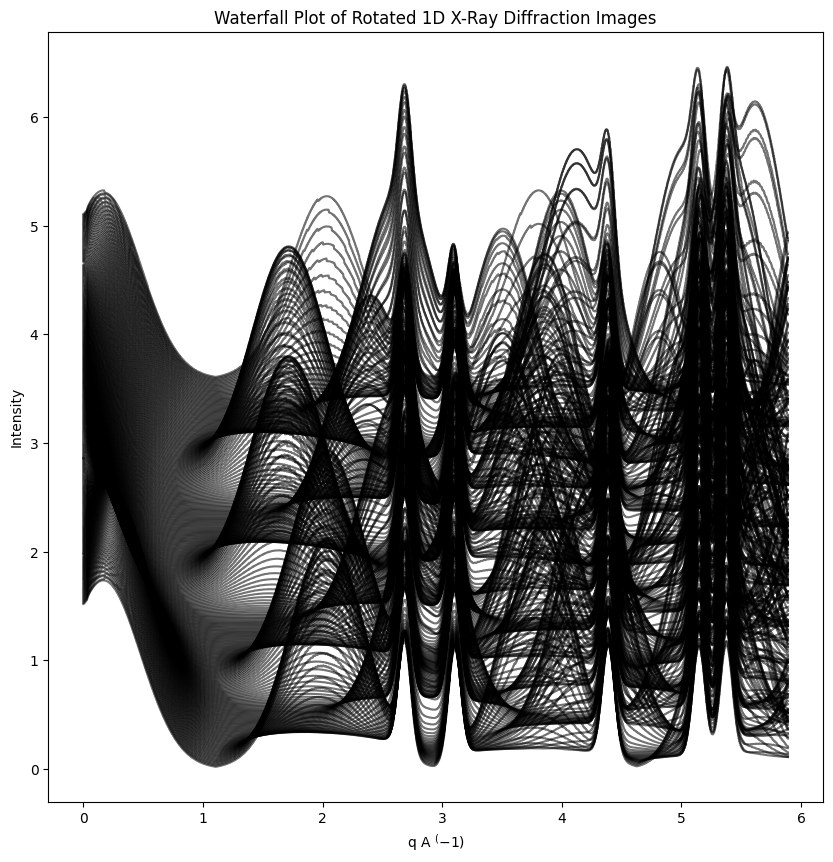

CPU times: user 7min 46s, sys: 1min 36s, total: 9min 22s
Wall time: 4min 1s


In [29]:
%%time 
q, data = sim.rotate_and_integrate(thin_film, 1, .4, .5e-10, resolution = 3000, mask = mask)

### Running IsoDAT2D on the generated data from rotate and integrate

In [ ]:
my_dict, my_comps = iso.run_nmfac(data, clusters = 7)

cluster_groups2 = {}
for cluster_num in set(my_dict['Cluster_Number']):
    cluster_groups2[cluster_num] = []

# Group the data based on cluster numbers
for cluster_num, int_angle in zip(my_dict['Cluster_Number'], my_dict['Int_Angle']):
    cluster_groups2[cluster_num].append(int_angle)
    
np.save('example.npy', cluster_groups2)

### Loading and sorting data into respective clusters

In [ ]:
#loading in the previously saved data
dataset = np.load('example.npy', allow_pickle=True)

#getting cluster 1 - 7
cluster1 = dataset.item().get(0)
cluster2 = dataset.item().get(1)
cluster3 = dataset.item().get(2)
cluster4 = dataset.item().get(3)
cluster5 = dataset.item().get(4)
cluster6 = dataset.item().get(5)
cluster7 = dataset.item().get(6)

#creating a consistent q value for all clusters
q = np.linspace(0, 25, 3000)

### Creating a visual to view all of the clusters

In [ ]:
fig, axs = plt.subplots(7,1, figsize=(20, 20))
fig.suptitle('Multi-Mask Experiment', fontsize=20)

# Plotting cluster one
for i in range(len(cluster1)):
    axs[0].plot(cluster1[i])
    axs[0].set_title(f'cluster one - Index {i}')

# Plotting cluster two
for i in range(len(cluster2)):
    axs[1].plot(cluster2[i])
    axs[1].set_title(f'cluster two - Index {i}')
    
# Plotting cluster two
for i in range(len(cluster3)):
    axs[2].plot(cluster3[i])
    axs[2].set_title(f'cluster three - Index {i}')
    
# Plotting cluster two
for i in range(len(cluster4)):
    axs[3].plot(cluster4[i])
    axs[3].set_title(f'cluster four - Index {i}')
    
# Plotting cluster two
for i in range(len(cluster5)):
    axs[4].plot(cluster5[i])
    axs[4].set_title(f'cluster five - Index {i}')
    
# Plotting cluster two
for i in range(len(cluster6)):
    axs[5].plot(cluster6[i])
    axs[5].set_title(f'cluster six - Index {i}')
    
# Plotting cluster two
for i in range(len(cluster7)):
    axs[6].plot(cluster7[i])
    axs[6].set_title(f'cluster seven - Index {i}')
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    
# Setting the x and y limits for all subplots
#for ax in axs.flat:
  #  ax.set_xlim(0, 350)
    #ax.set_ylim(-0.05, 0.6)

### Smoothing and Averaging clusters that look lik eisotropic signal

In [ ]:
avg_clust_list = [cluster5, cluster6]
averaged_clusters = np.array(iso.average_clusters(avg_clust_list))
smooth_clust = iso.smooth_averaged_cluster(averaged_clusters)

### Plotting the Isodat2d signals and the isotropic signal of interest

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(q, averaged_clusters)
plt.plot(q, smooth_clust)


plt.figure(figsize = (10,10))
plt.plot(q_reg, integrated_reg, c= 'b', label = 'Isotropic')

## DRAFT

In [ ]:
import pyFAI.azimuthalIntegrator as AI

combined_image = thin_film
distance = .4
wavelength = .5e-10
resolution = 3000
mask = None
show = False
radial_range = None


 # Initialize the detector
dete = pyFAI.detectors.Perkin()
p1, p2, p3 = dete.calc_cartesian_positions()
poni1 = p1.mean()
poni2 = p2.mean()

target = (0,0)
ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
#integrate the combined image using the azimuthal integrator

res0 = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask, method=("bbox", "csr", "opencl", target))
# print(ai.engines)

# if show == True:
#     #plot the 1D image
#     plt.figure(figsize=(10, 10))
#     plt.plot(q, I)
#     plt.title("1D X-Ray Diffraction Image")
#     plt.show()


In [ ]:
# Initialize the AzimuthalIntegrator
# ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
ai.engines

In [ ]:
engine = ai.engines[res0.method].engine
engine

In [ ]:
import pyFAI.azimuthalIntegrator as AI

@time_function
def integrate_image(combined_image, distance, wavelength, resolution = 3000, mask = None, show = False, radial_range = None):
    """
    This function integrates the combined image using the azimuthal integrator and displays the 1D image.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
    """
    #initialize the azimuthal integrator
    
     # Initialize the detector
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = p1.mean()
    poni2 = p2.mean()
    
    target = (0,0)
    ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
    #integrate the combined image using the azimuthal integrator
    q, I = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask, method=("bbox", "csr", "cython", target))

    if show == True:
        #plot the 1D image
        plt.figure(figsize=(10, 10))
        plt.plot(q, I)
        plt.title("1D X-Ray Diffraction Image")
        plt.show()
    
    return q, I

In [ ]:
def rotate_and_integrate(combined_image, angle_of_rotation, distance, wavelength, resolution = 3000, mask = None):
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, and rotates the combined image by a user specified angle amount, if the angle specified is 1, the result will be 360 integrations of the combined image, each integration will be rotated by 1 degree.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
    """
    
    import pandas as pd 
    
    #create a dataframe to store the 1D integrations
    # df = pd.DataFrame()
    data = {}
    #create a loop that rotates the combined image by the user specified angle amount and integrates the image
    for i in range(0, 360, angle_of_rotation):
        #rotate the mask for the combined image
        rotated_image = image_rotation(combined_image, i);
        
        #integrate the rotated image
        # q, I = integrate_image(rotated_image, distance, wavelength, resolution, mask, show = False);
        I = integrate_image(rotated_image, distance, wavelength, resolution, mask, show = False);

        #add the 1D integration to the dataframe
        data[i] = I
    
    df = pd.DataFrame(data)    
    # #create a waterfall plot of the 1D integrations, where each dataset is moved up on the y axis by a multiple of .5
    plt.figure(figsize=(10, 10))
    for j in range(0, 360, angle_of_rotation):
            plt.plot(q, (df[j]+ j*.01), alpha = .55, c = 'black')
    plt.xlabel('q A $^(-1)$')
    plt.ylabel('Intensity')
    plt.title("Waterfall Plot of Rotated 1D X-Ray Diffraction Images")
    plt.show()  
    
    return q, df


In [ ]:
import os
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

# Your code that uses pyopencl


In [ ]:
#method=("bbox", "csr", "cython"or "opencl")
%time q, data = rotate_and_integrate(thin_film, 1, .4, .5e-10, resolution = 3000, mask = mask)